# BT4212 Homework 4 
## Search Engine Optimization and Analytics

Term: Fall 2024

*Individual Assignment, due Nov 3，23:59* 

## Submission Instruction

This homework contains several coding tasks and short-answer questions to explore several predictive models for page-rank. For coding part, please write codes in the corresponding cells. I may provide some comment lines as guideline. For short-answers, type your answer in the cells with **ANSWER: HERE**. Please double click those cells and directly input your answer.

I recommend you use Python 3 for this homework. Python 2 may not be supported. You can use either your own PC or Google Colab to do this homework. GPU support is NOT required.


Save your notebook `.ipynb` file as `StudentID_YourName_HW4.ipynb`. Generate an `.html` file from `.ipynb` file and save as `StudentID_YourName_HW4.html`. Zip your notebook file and html file into a single `.zip` file. 

Upload the `zip` file as `StudentID_YourName_HW4.zip`. Please DO NOT include data file in your zip file (too large to upload and download).

**Please make sure your code is executable.**

If you are using Google Colab, 
* Please make sure you have expanded all hidden cells. You can refer to https://stackoverflow.com/questions/62457417/unhide-all-cells-in-google-colab for more information.
* How to generate an HTML file from your notebook file in Google Colab? Please refer to https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab

HW4 is worth 80 points in total.

### Install Necessary Packages

In [ ]:
!pip install --upgrade Cython
!pip install --upgrade git+https://github.com/statsmodels/statsmodels
!pip install xgboost # use the newest version

### Get Started

In [1]:
# Input your name and studentID
name = "your name"
stuID = "A0123456Z"

In [1]:
# Import packages
# the recommended version is listed but you could try using the most updated one.
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

import xgboost as xgb
from xgboost import plot_importance

from sklearn import metrics 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor



In [2]:
# To fix random seeds (Note that you may still get slightly different results.)
np.random.seed(12345)

# To ignore some warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)


## Background Information: About the Data
The data set is acquired in the following steps.
1. Identify a set of 20 keywords. 
2. For each keyword, search in google, and return the first 98 websites. It has $20\times98=1960$ observations in total.
3.  Split the dataset into training and test (or validation) data. The training data includes $70\%$ of observations ($14\times 98=1372$ rows) while the test one has $30\%$ of observations ($6\times 98=588$ rows). 

There are two data files. `Train_dta.csv` for training data and `Test_dta.csv` for testing data. Open the data file with Excel may encounter some unexpected errors. Simply download another copy from Canvas, if it occurs.

### Load Data

In [3]:
# Load the training and test datasets and print the first 5 rows of the training dataset.
# Please use pd.read_csv("data.csv") to load your data
# Run this cell

feature_col = [
    "TitleFlag",
    "TitleDensity",
    "URLFlag",
    "URLDensity",
    "MetaFlag",
    "MetaDensity",
    "PageAuthority",
    "DomainAuthority",
    "LinkingDomain",
    "InboundLink",
    "RankingKeyword",
]
train_data = pd.read_csv(
    "https://raw.githubusercontent.com/yunmeng-genius/BT4212/refs/heads/master/hw4/Train_dta.csv"
)
test_data = pd.read_csv(
    "https://raw.githubusercontent.com/yunmeng-genius/BT4212/refs/heads/master/hw4/Test_dta.csv"
)
train_data.head()

,ID,Position,ReverseRank,Title,URL,Meta,TitleFlag,TitleDensity,URLFlag,URLDensity,MetaFlag,MetaDensity,PageAuthority,DomainAuthority,LinkingDomain,InboundLink,RankingKeyword
0,1,1,100,Job Interview Questions Singapore: Answers to ...,https://blog.carousell.com/job-interview-quest...,sep 19 2017 common job interview questions in ...,0,0.3000,0,0.4286,0,0.1017,32,60,4,5.0,4
1,2,2,99,Job Interview Questions - Hudson Singapore,https://www.hudson.sg/career-advice/job-interv...,discover the five most common job interview qu...,0,0.6000,0,0.2500,0,0.2174,19,30,0,0.0,9
2,3,3,98,20 tips that will help you ace your next job i...,http://www.asiaone.com/business/20-tips-will-h...,oct 8 2017 with singapore's unemployment rate ...,0,0.2143,0,0.2143,0,0.0645,40,80,3,400.0,0
3,4,4,97,Common interview questions and answers | Rober...,https://www.roberthalf.com.sg/career-advice/in...,knowing what job interview questions you might...,0,0.1429,0,0.1111,0,0.2500,22,40,0,0.0,4
4,5,5,96,10 Common Interview Questions and How to ... -...,http://gradsingapore.com/graduate-careers-advi...,don't be caught off guard in an interview try ...,0,0.2000,0,0.0714,0,0.1429,24,33,2,2.0,6


There are many columns in the data, e.g., title, url and meta desciptions. The detailed information about each column is in the appendix. We will only use: “TitleFlag”, “TitleDensity”, “URLFlag”, “URLDensity”, “MetaFlag”, “MetaDensity”, “PageAuthority”, “DomainAuthority”, “LinkingDomain”, “InboundLink” and “RankingKeyword” as features, **"ReverseRank" as label**.

In [4]:
# Split feature and label
# Run this cell

train_feature = train_data[feature_col]
train_label = train_data["ReverseRank"]

test_feature = test_data[feature_col]
test_label = test_data["ReverseRank"]


In [5]:
# Run this cell
print(train_feature.shape,
      train_label.shape,
      test_feature.shape,
      test_label.shape)

(1372, 11) (1372,) (588, 11) (588,)


In [6]:
# Run this cell
# This serves as your data input
X_train = train_feature # trainig feature, as a dataframe in pandas
X_test = test_feature # test feature, as a df 

y_train = train_label.values # training label, as a numpy array
y_test = test_label.values # test label, as a np array


To avoid potential issues of shallow copy and deep copy. Try to load data separately for each problem, although they may be the same.

## Problem 1 Pointwise Rank. (35 points)

###  Q1. Linear Regression (10 points)
Please use the training dataset to fit a linear regression with all variables aforementioned. Please use the trained linear regression model to predict the rank in the test dataset and **report the root mean square error (RMSE) of the prediction**, i.e., $\sqrt{\frac{1}{n}\sum_{i=1}^n(y_i-\hat{y}_i)^2}$, where $n$ is the total number of data points in the test dataset, $y_i$ is the true value of the outcome variable in the test dataset, and $\hat{y}_i$ is the model prediction of the outcome variable. (5 points)

Reference: https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html

In [7]:
# Data Input


In [8]:
# Model: USE sm.OLS(y_train, X_train)
# Fit: USE model.fit()
# y_train is a numpy array from train_label, X_train is a pandas dataframe from train_feature.
# Remember to add an intercept by sm.add_constant() to both train and test data!


In [9]:
# Print model summary by model.summary()


In [10]:
# Make prediction 



In [11]:
# Print RMSE, y_test is a numpy array from test_label, y_pred is a numpy array from your model prediction


**Pick the most statistically significant variable and interpret its estimated beta coefficient.** (5 points)

*ANSWER: HERE*


### Q2. Logistic Regression (15 points)

For the baseline logistic regression, it does not require an ordinal relationship among the levels of the outcome variable, e.g., level 1 does not necessarily imply superiority or inferiority compared with level 2. However, for ordinal variable, its levels can be ranked implying a higher value than other level, e.g., in the school grade, A is better than B. We will use **ordinal** logistic regression for this problem.

Please use the training dataset to fit an **ordinal** logistic regression model with all variables aforementioned. **Use the `ReverseRank` as the outcome variable**, that is apparently a ranked variable**. (5 points)

Note that you may not be able to run ordinal logistic regression because the distributions of several variables are too skewed. You can use `new_variable = np.log(the_problematic_variable+1)` to **transform those variables in both training and testing data.** (5 points)

Please use the trained ordinal logistic regression model to predict the rank in the test dataset. **Print the predicted rank on the test dataset and report the RMSE of the prediction.** （5 points） 

Reference: https://www.statsmodels.org/dev/examples/notebooks/generated/ordinal_regression.html.
https://stats.oarc.ucla.edu/r/dae/ordinal-logistic-regression/. 

Remarks: You will find tons of useful materials about statistical modelling in UCLA website, even though mostly implemented with R or Stata.

In [12]:
# Data Input


In [13]:
# Adjust your input
# Please specify which parts of data you do a log transformation on.
# There are many ways to determine the skewness, 
# e.g., plotting the distribution, calling pandas.DataFrame.skew, etc.
# As long as you provide reasons for the transformation, you will be awarded the points.


In [14]:
# Model: use OrderedModel(y_train, X_train, distr='logit')
# Fit: use model.fit(method='bfgs', disp=False)
# y_train is a numpy array from train_label, X_train is a pandas dataframe from train_feature.


In [15]:
# Print model summary by model.summary()


In [16]:
# Make prediction: assume the predicted output of this model is y_pred, 
# for this question, you need to do y_pred.argmax(1)+3 to get the real output.
# Please refer to the reference above for how to make prediction properly.


In [17]:
# Print RMSE, y_test is a numpy array from test_label, y_pred is a numpy array from your model prediction


Pick the most statistically significant variable and interpret its estimated beta coefficient. (5 points)

*ANSWER: HERE*


### Q3. Decision Tree (5 points)
Please use the training dataset to fit a decision tree model with all variables aforementioned. **Use the `ReverseRank` as the target variable**. 


In [18]:
# Data Input


In [19]:
# Model & Fit: USE DecisionTreeRegressor(random_state=0).fit(...)
# y_train is a numpy array from train_label, X_train is a pandas dataframe from train_feature.
# Make prediction 


In [20]:
# Print RMSE, y_test is a numpy array from test_label, y_pred is a numpy array from your model prediction


###  Q4. Random Forest (5 points)
Please use the training dataset to fit a random forest model with all variables aforementioned. **Use the `ReverseRank` as the target variable**. 


In [21]:
# Data Input 


In [22]:
# Model & Fit: USE RandomForestRegressor(random_state=0).fit(...)
# y_train is a numpy array from train_label, X_train is a pandas dataframe from train_feature.
# Make prediction 


In [23]:
# Print RMSE, y_test is a numpy array from test_label, y_pred is a numpy array from your model prediction


## Problem 2. Pairwise Rank with `xgboost` (35 points)
Please use the training dataset to fit an XGboost model with all variables aforementioned. **Use the `ReverseRank` as the target variable**. 

Show the feature importance plot. Use "Gain" for `measure` in the importance plot. 

For the XGboost prediction, please interpret the importance value of the most important variable. Please use the trained XGboost model to predict the rank in the test dataset and report the RMSE of the prediction. 

Reference: https://xgboost.readthedocs.io/en/latest/python/index.html

In [24]:
# Data Input


### Q1. Use `reg:linear` for `objective` and `rmse` for `eval_metric`. (10 points)


In [25]:
# Model and Parameter Setting 
# Use xgb.XGBRegressor
# Use parameters below first and you can adjust it later.
reg = xgb.XGBRegressor(max_depth = 6, 
                       eta = 0.1, 
                       gamma = 0.1,
                       subsample = 0.8,
                       colsample_bytree = 0.8,
                       alpha = 0.5,
                       objective = "reg:linear",
                       eval_metric = "rmse",
                       seed = 1)

In [26]:
# Fit the model by your_model.fit(X_train, y_train)
reg.fit(X_train, y_train)

e:\software_pro\miniconda3\envs\myenvnew\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:30:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(alpha=0.5, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric='rmse',
             feature_types=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

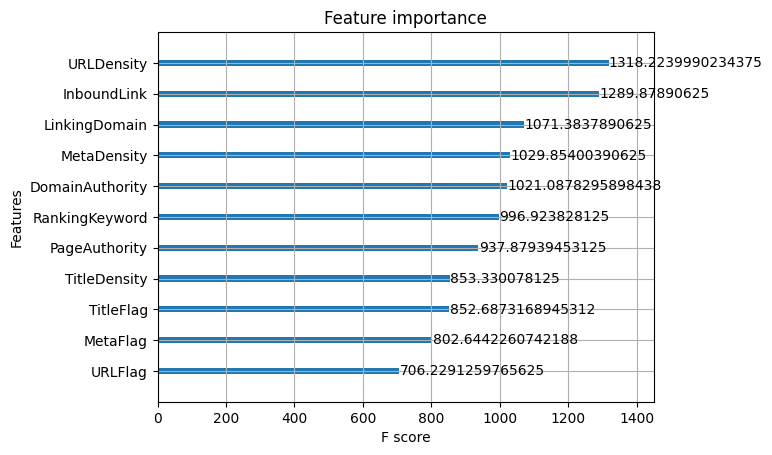

In [27]:
# Show the feature importance plot. Use plot_importance(your_model, importance_type = 'gain')
# If you don't see your plot, please run this cell again.
plot_importance(reg, importance_type = 'gain')

**Please interpret the importance value of the most important variable.** (5 points)

*ANSWER: HERE*


In [28]:
# Make prediction: y_pred should be the output of your prediction, it cotains value
# from 3 to 100 (may not be integers)


In [29]:
## Print RMSE, y_test is a numpy array from test_label, y_pred is a numpy array from your model prediction



**Try different combinations of the hyper-parameters to get a lower RMSE.** (5 points)

Please note that you can use any hyper-parameter tuning techniques in the lecture. The points are not awarded based on the exact number of RMSE. As long as it is lower than the original values and you can justify the technique you use, you will be awarded the points.

In [30]:
# your code here...


### Q2. Redo Q1 by using `rank:pairwise` for `objective` and `rmse` for `eval_metric`. (15 points)
Observe that we did not utilize the query information yet. However, in the dataset, we know that each query corresponds to 98 data points. Now we will leverage this information by setting group information for both training and testing data. (5 points)



In [31]:
# Model and Parameter Setting 
# Use xgb.XGBRanker
# Use parameters below first and you can adjust it later.
reg = xgb.XGBRanker(max_depth = 6, 
                           eta = 0.1, 
                           gamma = 0.1,
                           subsample = 0.8,
                           colsample_bytree = 0.8,
                           alpha = 0.5,
                           objective = "rank:pairwise",
                           eval_metric = "rmse")

In [32]:
# Data Input


In [33]:
# Fit the model by your_model.fit(X_train, y_train, group = np.full(14,98))


In [34]:
# Show the feature importance plot. Use plot_importance(your_model, importance_type = 'gain')


**Please interpret the importance value of the most important variable.** (5 points)

*ANSWER: HERE*


Note that here `y_pred` is *not* a direct rank on itself. We need to figure out how to get the rank from `y_pred`. Test data can be divided into 6 groups, we need to perform the following steps for each group.
1. For each group, get `y_pred` from your model. 
2. The values in `y_pred` indicate a relative score for the rank. The higher the score, the better the page rank. For all 98 pages in one group, the page with the highest score should rank as 100, and the page with the lowest score should rank as 3. 
3. Repeat this for all groups. You are required to implement this by some simple codes. **y_pred_rank** is the predicted ranks you transformed from **y_pred**.



In [35]:
# Make prediction: y_pred is the predicted output from your model, y_pred_rank is the actual rank you get


In [36]:
# Print RMSE, y_test is a numpy array from test_label, y_pred_rank is a numpy array from your model prediction


**Try different combinations of the hyper-parameters to get a lower RMSE.** (5 points)

Please note that you can use any hyper-parameter tuning techniques in the lecture. The points are not awarded based on the exact number of RMSE. As long as it is lower than the original values and you can justify the technique you use, you will be awarded the points.

In [37]:
# your code here...


### Q3. Use `rank:ndcg` for `objective` and `rmse` for `eval_metric`. Redo Question 6. (10 points)

In [38]:
# Model and Parameter Setting 
# Use xgb.XGBRanker
# Use parameters below first and you can adjust it later.
reg = xgb.XGBRanker(max_depth = 6, 
                           eta = 0.1, 
                           gamma = 0.1,
                           subsample = 0.8,
                           colsample_bytree = 0.8,
                           alpha = 0.5,
                           objective = "rank:ndcg",
                           eval_metric = "rmse",
                           ndcg_exp_gain = False) # please note that because we have more than 32 labels, we need to set ndcg_exp_gain = False

In [39]:
# Data Input


In [40]:
# !pip install xgboost==1.5.0

In [41]:
# Fit the model by your_model.fit(X_train, y_train, group = np.full(14,98))

In [42]:
# Show the feature importance plot. Use plot_importance(your_model, importance_type = 'gain')


**Please interpret the importance value of the most important variable.** (5 points)

*ANSWER: HERE*


In [43]:
# Make prediction: y_pred is the predicted output from your model, y_pred_rank is the actual rank you get


In [44]:
# Print RMSE, y_test is a numpy array from test_label, y_pred_rank is a numpy array from your model prediction


**Try different combinations of the hyper-parameters to get a lower RMSE.** (5 points)

Please note that you can use any hyper-parameter tuning techniques in the lecture. The points are not awarded based on the exact number of RMSE. As long as it is lower than the original values and you can justify the technique you use, you will be awarded the points.

In [45]:
# your code here...


## Problem 3. Interpretation Short-Answers (10 points)

Please paste the RMSE values of all questions above in the table below. Please round your RMSE up to 4 decimals.

To access the table written in markdown below, double click the placeholder table, edit the corresponding value and run the cell. 


Before Tuning:

| Question | P1-Q1 | P1-Q2 | P1-Q3 | P1-Q4 | P2-Q5 | P2-Q6 | P2-Q7 |
| --- | --- | --- | --- | --- | --- | --- | --- |
| RMSE | 1.0000 | 2.0000 | 3.0000 | 4.0000 | 5.0000 | 6.0000 | 7.0000 |

After Tuning:

| Question | P2-Q5 | P2-Q6 | P2-Q7 |
| --- | --- | --- | --- | 
| RMSE |  5.0000 | 6.0000 | 7.0000 |

**Question: Please describe what you observe from the RMSE value for all methods of pointwise ranking. What is the best method? Why? (5 points)**

Answer: HERE

**Question: Please compare the results from pointwise ranking and pairwise ranking and describe your observatins.(5 points)**

Answer: HERE

# Appendix

1. ID: identification number (i.e., row number in the dataset)

2. Position: the actual google ranking of the webpage to the query

3. ReverseRank: equals $101$ minus Position. It is equivalent to the position. Sometimes using ReverseRank as the dependent variable can have a better prediction.

4. Title: the title of the webpage

5. URL: the URL of the webpage

6. Meta: the meta description of the webpage

7.	TitleFlag: indicates that whether the whole keyword is included in the page title. TitleFlag equals 1 if yes, otherwise, 0.

8.	UrlFlag: indicates that whether the whole keyword is included in the page url. UrlFlag equals 1 if yes, otherwise, 0.

9.	MetaFlag: indicates that whether the whole keyword is included in the page meta description. MetaFlag equals 1 if yes, otherwise, 0.

10.	TitleDensity: is the percentage of times a keyword appears in the title of a web page compared to the total number of words in the title of a web page.

11.	UrlDensity: is the percentage of times a keyword appears in the URL of a web page compared to the total number of words in the URL of a web page.

12.	MetaDensity: is the percentage of times a keyword appears in the meta description of a web page compared to the total number of words in the meta description of a web page.

13.	PageAuthority: is a score developed by Moz that predicts how well a specific page will rank on search engine result pages (SERP). https://moz.com/learn/seo/page-authority

14.	DomainAuthority: is a search engine ranking score developed by Moz that predicts how well a website will rank on search engine result pages (SERPs). https://moz.com/learn/seo/domain-authority

15.	LinkingDomain: is the number of unique external domains linking to this page. Two or more links from the same websites are considered as one linking domain. Provided by Moz.

16.	InboundLink: is the number of unique external pages linking to this page. Two or more links from the same page on a website are considered as one inbound link. Provided by Moz.

17.	RankingKeyword: is the number of keywords for which this site ranks within the top 50 positions on Google US. Provided by Moz.